# Figures for synthetic FWI
Used in the Geophysics paper and the thesis

In [1]:
import sys

pwd = !echo ${PWD}
sys.path.append(pwd[0]+"/../../../code/local/bin")

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy import ndimage
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

import seppy
import os

sep = seppy.sep()

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

datapath=pwd[0]+"/../dat/"
figpath=pwd[0]+"/../fig/"

In [3]:
# utility functions

def plotvel(d, plotvs=True, title1=None, title2=None, vpmin=2.6, vpmax=5.5, vsmin=1.6, vsmax=2.7, cmap1="seismic", cmap2="seismic", clabel1 = "Velocity (km/s)", clabel2 = "Velocity (km/s)", grid=True, srxz=np.array([]), plot_rec=True, savefig=None):
    """Plot Vp and Vs models"""

    if plotvs==True:                
        fig=plt.figure(figsize=(6.66, 2),dpi=300)
        plt.subplot(1,2,1)
    else:
        fig=plt.figure(figsize=(4.33, 2),dpi=300)
    plt.imshow(np.transpose(d[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap=cmap1,vmin=vpmin,vmax=vpmax)
    plt.xlabel('X (km)')
    plt.ylabel('Depth (km)')
    if plotvs==True:
        if title1==None:
            plt.title(r"a) $V_{\mathrm{P}}$",loc='left')
        else:
            plt.title(r""+title1,loc='left')
    if grid==True:
        plt.grid(color='k', linestyle='-', linewidth=0.2)
    cbar = plt.colorbar(shrink=0.7, format="%.1f",pad=0.02)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label(label=clabel1,size=6)
    if srxz.size>0:
        if plot_rec==True:
            plt.scatter(srxz[:,:,3], srxz[:,:,4], s=0.5, c='y', marker='.',linewidths=0.5)
        plt.scatter(srxz[:,0,1], srxz[:,0,2], s=30, c='m', marker='x',linewidths=1)
    plt.gca().tick_params(axis='both', which='major', labelsize=6)

    if plotvs==True:
        plt.subplot(1,2,2)
        plt.imshow(np.transpose(d[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap=cmap2,vmin=vsmin,vmax=vsmax)
        plt.xlabel('X (km)')
        plt.gca().set_yticklabels([])
        if title2==None:
            plt.title(r"b) $V_{\mathrm{S}}$", loc='left')
        else:
            plt.title(r""+title2, loc='left')
        if grid==True:
            plt.grid(color='k', linestyle='-', linewidth=0.2)
        cbar = plt.colorbar(shrink=0.7, format="%.1f",pad=0.02)
        cbar.ax.tick_params(labelsize=6)
        cbar.set_label(label=clabel2,size=6)
        if srxz.size>0:
            if plot_rec==True:
                plt.scatter(srxz[:,:,3], srxz[:,:,4], s=0.5, c='y', marker='.',linewidths=0.5)
            plt.scatter(srxz[:,0,1], srxz[:,0,2], s=30, c='m', marker='x',linewidths=1)
        plt.gca().tick_params(axis='both', which='major', labelsize=6)
    
    plt.tight_layout()

    if savefig != None:
        plt.savefig(figpath+str(savefig)+'.png',bbox_inches='tight',format='png')
    else:
        plt.show()


def plotfunc(x, y, ymin=0, ymax=1, yscale="linear", ylabel="Value", labels=[], legend=True, savefig=None):
    """Plot misfit functions"""

    if len(labels)>0:
        assert (len(labels) == len(y))
    else:
        for i in range(len(y)):
            label = "Curve "+str(i+1)
            labels.append(label)
                
    fig=plt.figure(figsize=(3.33, 2),dpi=300)

    for i in range(len(y)):
        plt.plot(x[i],y[i],label=labels[i],Linewidth=1)
    if legend==True:
        plt.legend()
    plt.xlabel("Iteration number")
    plt.ylabel(ylabel)
    if ymin!=ymax:
        plt.ylim([ymin,ymax])
    plt.yscale(yscale)
    plt.gca().tick_params(axis='both', which='major', labelsize=6)

    if savefig != None:
        plt.savefig(figpath+str(savefig)+'.png',bbox_inches='tight',format='png')
    else:
        plt.show()

In [4]:
# simple 1D model with 3 sources to create an example image for the weighting operator
n=31
i1=9
i2=14
i3=23
width=4
b1d=np.ones(n)
b1=np.ones(n)
b2d=np.ones(n)
b2=np.ones(n)
b3d=np.ones(n)
b3=np.ones(n)
taper=np.ones(width+1)
for i in range(width+1):
    taper[i]=math.cos(math.pi/2 * 0.8*i/(width))
taper=taper**2

b1[i1-width:i1+1] = taper
b1[i1:i1+width+1] = np.flip(taper)
b1d[:] = b1[:] 
b1[0:width+1] = np.flip(taper)
b2[i2-width:i2+1] = taper
b2[i2:i2+width+1] = np.flip(taper)
b2d[:] = b2[:] 
b3[i3-width:i3+1] = taper
b3[i3:i3+width+1] = np.flip(taper)
b3d[:] = b3[:] 
b3[n-width-1:n] = taper

W=np.zeros((3*n,3*n))
W[0:n,0:n] = np.diag(b1d)
W[n:2*n,n:2*n] = np.diag(b2d)
W[2*n:3*n,2*n:3*n] = np.diag(b3d)

W[0:n,n:2*n] = np.diag((1-b1d)*b2/(b2+b3))
W[0:n,2*n:3*n] = np.diag((1-b1d)*b3/(b2+b3))
W[n:2*n,0:n] = np.diag((1-b2d)*b1/(b1+b3))
W[n:2*n,2*n:3*n] = np.diag((1-b2d)*b3/(b1+b3))
W[2*n:3*n,0:n] = np.diag((1-b3d)*b1/(b1+b2))
W[2*n:3*n,n:2*n] = np.diag((1-b3d)*b2/(b1+b2))

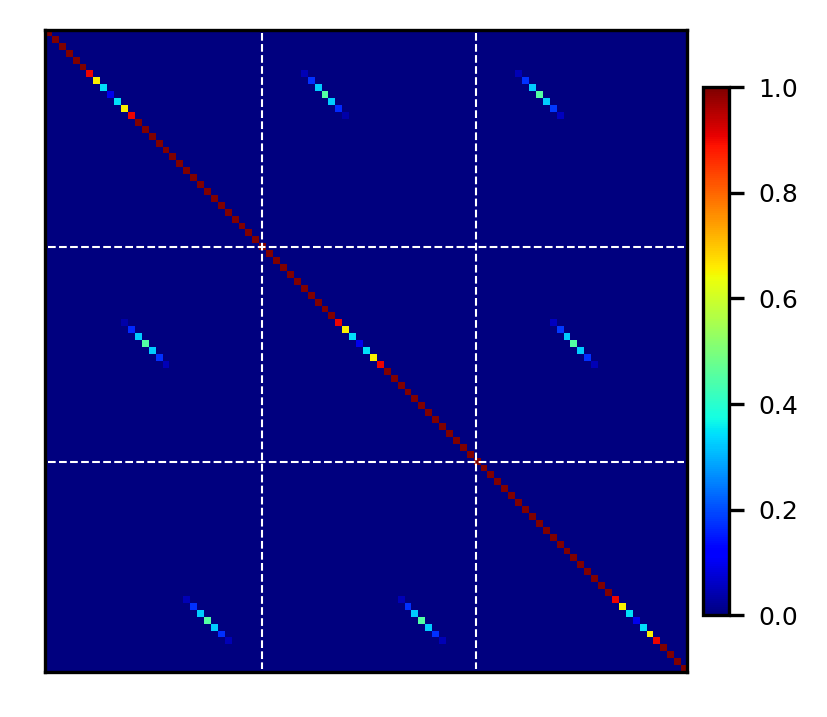

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3.33, 3.33),dpi=300)
im=plt.imshow(W,interpolation='none', vmin=0, vmax = 1, cmap='jet')
plt.vlines(n,0,3*n-1,linestyles='--',linewidth=0.5,color='w')
plt.vlines(2*n,0,3*n-1,linestyles='--',linewidth=0.5,color='w')
plt.hlines(n,0,3*n-1,linestyles='--',linewidth=0.5,color='w')
plt.hlines(2*n,0,3*n-1,linestyles='--',linewidth=0.5,color='w')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
cbar=fig.colorbar(im, ax=ax, orientation='vertical',shrink=0.7, format="%.1f",pad=0.02)
cbar.ax.tick_params(labelsize=6)

plt.savefig(figpath+'ch5sy_weighting_matrix.png',bbox_inches='tight',format='png')

In [4]:
# read sensitivity Kernels for acoustic and elastic media
axes, data = sep.read_file(datapath+"ch5sy_acoustic_kernel.H.gradient_iter_0.H")
ch5sy_acoustic_kernel = data.reshape(axes.n,order='F').T
ch5sy_acoustic_kernel = ch5sy_acoustic_kernel[0,50:151,50:151]
ch5sy_acoustic_kernel /= np.max(np.abs(ch5sy_acoustic_kernel))

axes, data = sep.read_file(datapath+"ch5sy_elastic_kernel.H.gradient_iter_0.H")
ch5sy_elastic_kernel = data.reshape(axes.n,order='F').T
ch5sy_elastic_kernel = ch5sy_elastic_kernel[0:2,50:151,50:151]
ch5sy_elastic_kernel[0] /= np.max(np.abs(ch5sy_elastic_kernel[0]))
ch5sy_elastic_kernel[1] /= np.max(np.abs(ch5sy_elastic_kernel[1]))

axes, data = sep.read_file(datapath+"ch5sy_elastic_kernel_mt.H.gradient_iter_0.H")
ch5sy_elastic_kernel_mt = data.reshape(axes.n,order='F').T
ch5sy_elastic_kernel_mt = ch5sy_elastic_kernel_mt[0:2,50:151,50:151]
ch5sy_elastic_kernel_mt[0] /= np.max(np.abs(ch5sy_elastic_kernel_mt[0]))
ch5sy_elastic_kernel_mt[1] /= np.max(np.abs(ch5sy_elastic_kernel_mt[1]))

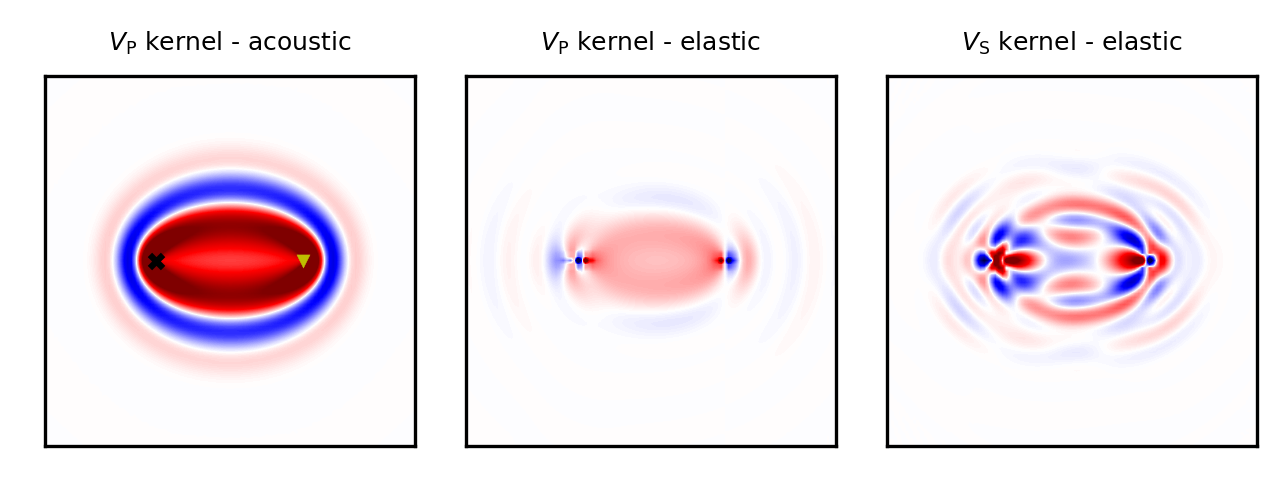

In [7]:
# Sensitivity kernels figure

plt.figure(figsize=(4.33, 6),dpi=300)

p=0.5
cmap="seismic"
plt.subplot(1,3,1)
plt.imshow(np.transpose(ch5sy_acoustic_kernel), interpolation='bilinear', vmin=-p, vmax = p, cmap=cmap)
plt.scatter([30], [50], s=10, c='k', marker='x',linewidths=0.1)
plt.scatter([70], [50], s=10, c='y', marker='v',linewidths=0.1)
plt.title(r"$V_{\mathrm{P}}$ kernel - acoustic",size=6)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
# plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.transpose(ch5sy_elastic_kernel_mt[0]), interpolation='bilinear', vmin=-p, vmax = p, cmap=cmap)
# plt.scatter([30], [50], s=10, c='k', marker='x',linewidths=0.1)
# plt.scatter([70], [50], s=10, c='y', marker='v',linewidths=0.1)
plt.title(r"$V_{\mathrm{P}}$ kernel - elastic",size=6)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
# plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.transpose(ch5sy_elastic_kernel_mt[1]), interpolation='bilinear', vmin=-p, vmax = p, cmap=cmap)
# plt.scatter([30], [50], s=10, c='k', marker='x',linewidths=0.1)
# plt.scatter([70], [50], s=10, c='y', marker='v',linewidths=0.1)
plt.title(r"$V_{\mathrm{S}}$ kernel - elastic",size=6)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
# plt.axis('off')
plt.tight_layout()

plt.savefig(figpath+'ch5sy_kernels.png',bbox_inches='tight',format='png')

In [4]:
# read models and cut them to the useful part

sep = seppy.sep()

axes, data = sep.read_file(datapath+"ch5sy_model0.H")
ch5sy_model0 = data.reshape(axes.n,order='F').T
ch5sy_model0 = ch5sy_model0[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_model1.H")
ch5sy_model1 = data.reshape(axes.n,order='F').T
ch5sy_model1 = ch5sy_model1[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi0.H")
ch5sy_fwi0 = data.reshape(axes.n,order='F').T
ch5sy_fwi0 = ch5sy_fwi0[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5.H")
ch5sy_fwi5 = data.reshape(axes.n,order='F').T
ch5sy_fwi5 = ch5sy_fwi5[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_data1.H.invHessian")
invHessian = data.reshape(axes.n,order='F').T
invHessian = invHessian[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_model0_ibs.H")
ch5sy_model0_ibs = data.reshape(axes.n,order='F').T
ch5sy_model0_ibs = ch5sy_model0_ibs[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H")
ch5sy_fwi0e = data.reshape(axes.n,order='F').T
ch5sy_fwi0e = ch5sy_fwi0e[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H.weights")
ch5sy_fwi0e_weights = data.reshape(axes.n,order='F').T
ch5sy_fwi0e_weights = ch5sy_fwi0e_weights[:,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H.ext")
ch5sy_fwi0e_ext = data.reshape(axes.n,order='F').T
ch5sy_fwi0e_ext = ch5sy_fwi0e_ext[:,:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5e.H")
ch5sy_fwi5e = data.reshape(axes.n,order='F').T
ch5sy_fwi5e = ch5sy_fwi5e[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5m.H")
ch5sy_fwi5m = data.reshape(axes.n,order='F').T
ch5sy_fwi5m = ch5sy_fwi5m[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5mb.H")
ch5sy_fwi5mb = data.reshape(axes.n,order='F').T
ch5sy_fwi5mb = ch5sy_fwi5mb[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5mh.H")
ch5sy_fwi5mh = data.reshape(axes.n,order='F').T
ch5sy_fwi5mh = ch5sy_fwi5mh[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5p.H")
ch5sy_fwi5p = data.reshape(axes.n,order='F').T
ch5sy_fwi5p = ch5sy_fwi5p[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5.H.gradient_iter_0.H")
ch5sy_fwi5_grad = data.reshape(axes.n,order='F').T
ch5sy_fwi5_grad = ch5sy_fwi5_grad[:2,:,30:71]

axes, data = sep.read_file(datapath+"ch5sy_fwi5p.H.gradient_iter_0.H")
ch5sy_fwi5p_grad = data.reshape(axes.n,order='F').T
ch5sy_fwi5p_grad = ch5sy_fwi5p_grad[:2,:,30:71]

# this is not really needed

Zn=axes.n[0] - 60
Xn=axes.n[1]
Zo=axes.o[0] + 0.3
Xo=axes.o[1]
Zd=axes.d[0]
Xd=axes.d[1]

# source-receivers geometry (refer to the Make file)
ns=3
ntr=141
srxz=np.zeros((ns,ntr,5))
srxz[0,:,0] = 1
srxz[0,:,1] = 0.4
srxz[0,:,2] = 0.5
srxz[0,:,3] = np.linspace(0.3,1.7,ntr)
srxz[0,:,4] = 0.5

srxz[1,:,0] = 1
srxz[1,:,1] = 1.0
srxz[1,:,2] = 0.5
srxz[1,:,3] = np.linspace(0.3,1.7,ntr)
srxz[1,:,4] = 0.5

srxz[2,:,0] = 1
srxz[2,:,1] = 1.6
srxz[2,:,2] = 0.5
srxz[2,:,3] = np.linspace(0.3,1.7,ntr)
srxz[2,:,4] = 0.5


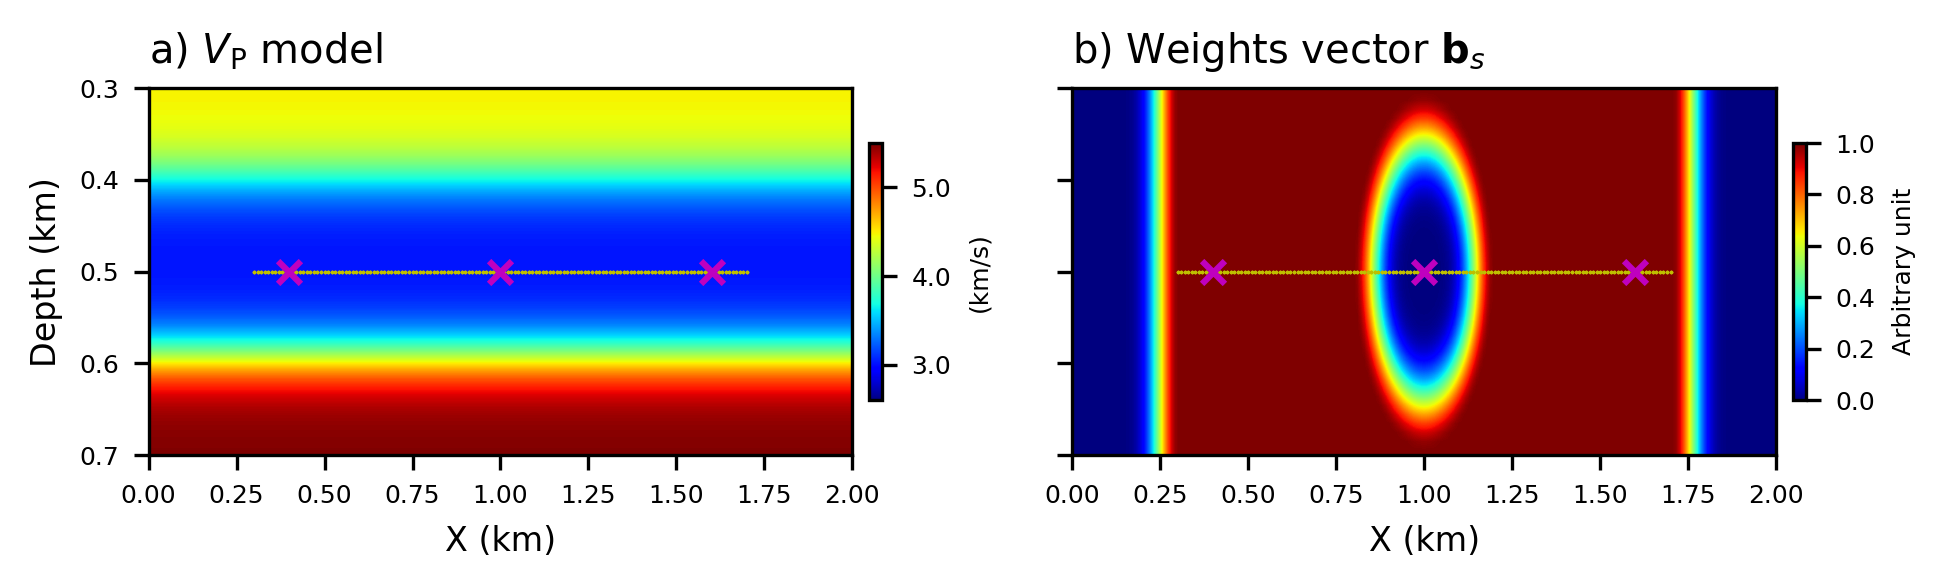

In [9]:
# problem setting, initial model and extension weights for the central source
temp = np.copy(ch5sy_model0)
temp [1,:,:] = ch5sy_fwi0e_weights[1:2,:,:]
plotvel(temp, plotvs=True, title1="a) $V_\mathrm{P}$ model", title2="b) Weights vector $\mathbf{b}_s$", vpmin=2.6, vpmax=5.5, vsmin=0, vsmax=1, cmap1="jet", cmap2="jet", clabel1 = "(km/s)", clabel2 = "Arbitrary unit", grid=False, srxz=srxz, plot_rec=True, savefig="ch5sy_setting")

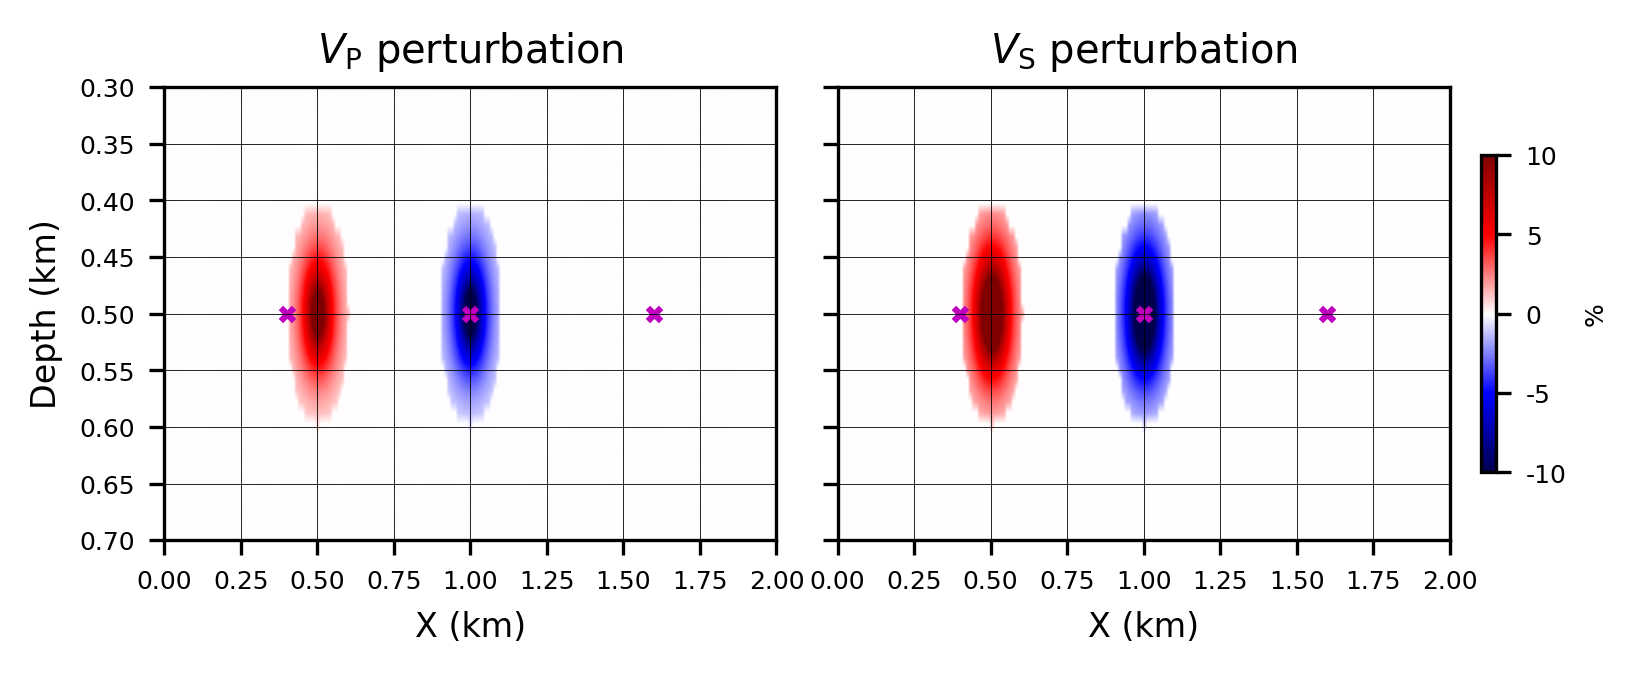

In [6]:
# True perturbations
temp = 100*(ch5sy_model1[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
# plotvel(temp, plotvs=True, title1="a) True $V_\mathrm{P}$ perturbation", title2="b) True $V_\mathrm{S}$ perturbation", vpmin=-0.2, vpmax=0.2, vsmin=-0.2, vsmax=0.2, grid=True, srxz=srxz, plot_rec=True, savefig="ch5sy_true_perturbations")

# fig=plt.figure(figsize=(6.66, 2),dpi=300)

fig, ax = plt.subplots(1,2,figsize=(6.66, 2),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.)

im0=ax[0].imshow(np.transpose(temp[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[0].set_title(r"$V_{\mathrm{P}}$ perturbation",loc='center')
ax[0].tick_params(axis='both', which='major', labelsize=6)
ax[0].grid(color='k', linestyle='-', linewidth=0.2)
ax[0].scatter(srxz[:,0,1], srxz[:,0,2], s=10, c='m', marker='x')

im1=ax[1].imshow(np.transpose(temp[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1].set(xlabel='X (km)')
ax[1].set_yticklabels([])
ax[1].set_title(r"$V_{\mathrm{S}}$ perturbation",loc='center')
ax[1].tick_params(axis='both', which='major', labelsize=6)
ax[1].grid(color='k', linestyle='-', linewidth=0.2)
ax[1].scatter(srxz[:,0,1], srxz[:,0,2], s=10, c='m', marker='x')

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.0f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="%",size=6)

# plt.tight_layout()

plt.savefig(figpath+'ch5sy_true_perturbations.png',bbox_inches='tight',format='png')

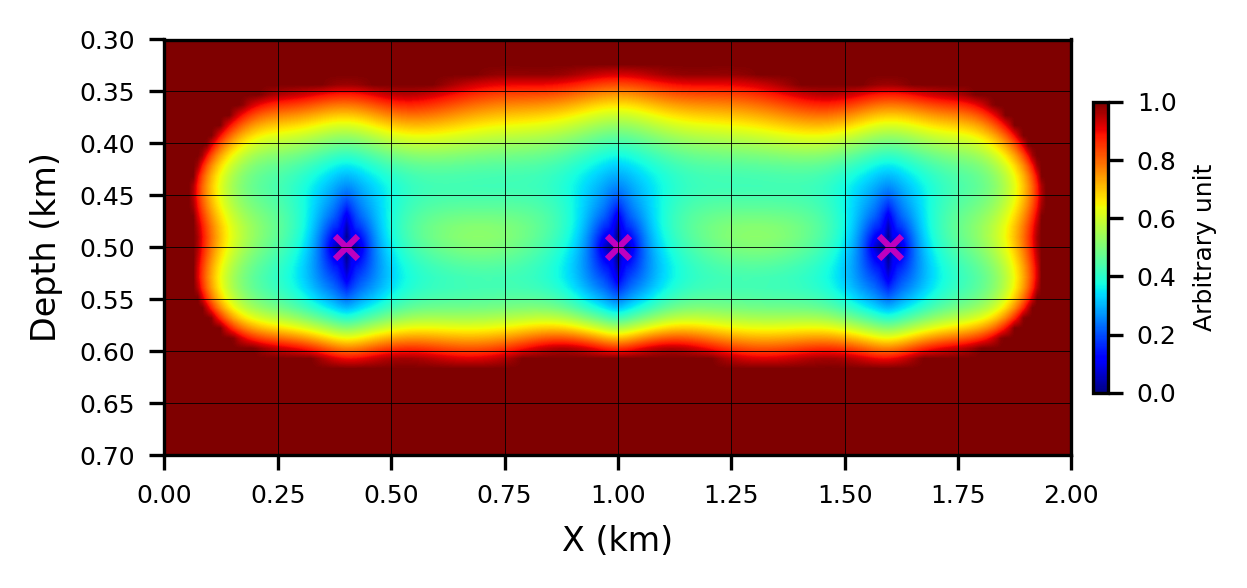

In [11]:
# inverse pseudo Hessian
plotvel(invHessian, plotvs=False, vpmin=0, vpmax=1, cmap1="jet", clabel1 = "Arbitrary unit", grid=True, srxz=srxz, plot_rec=False, savefig="ch5sy_invHessian")

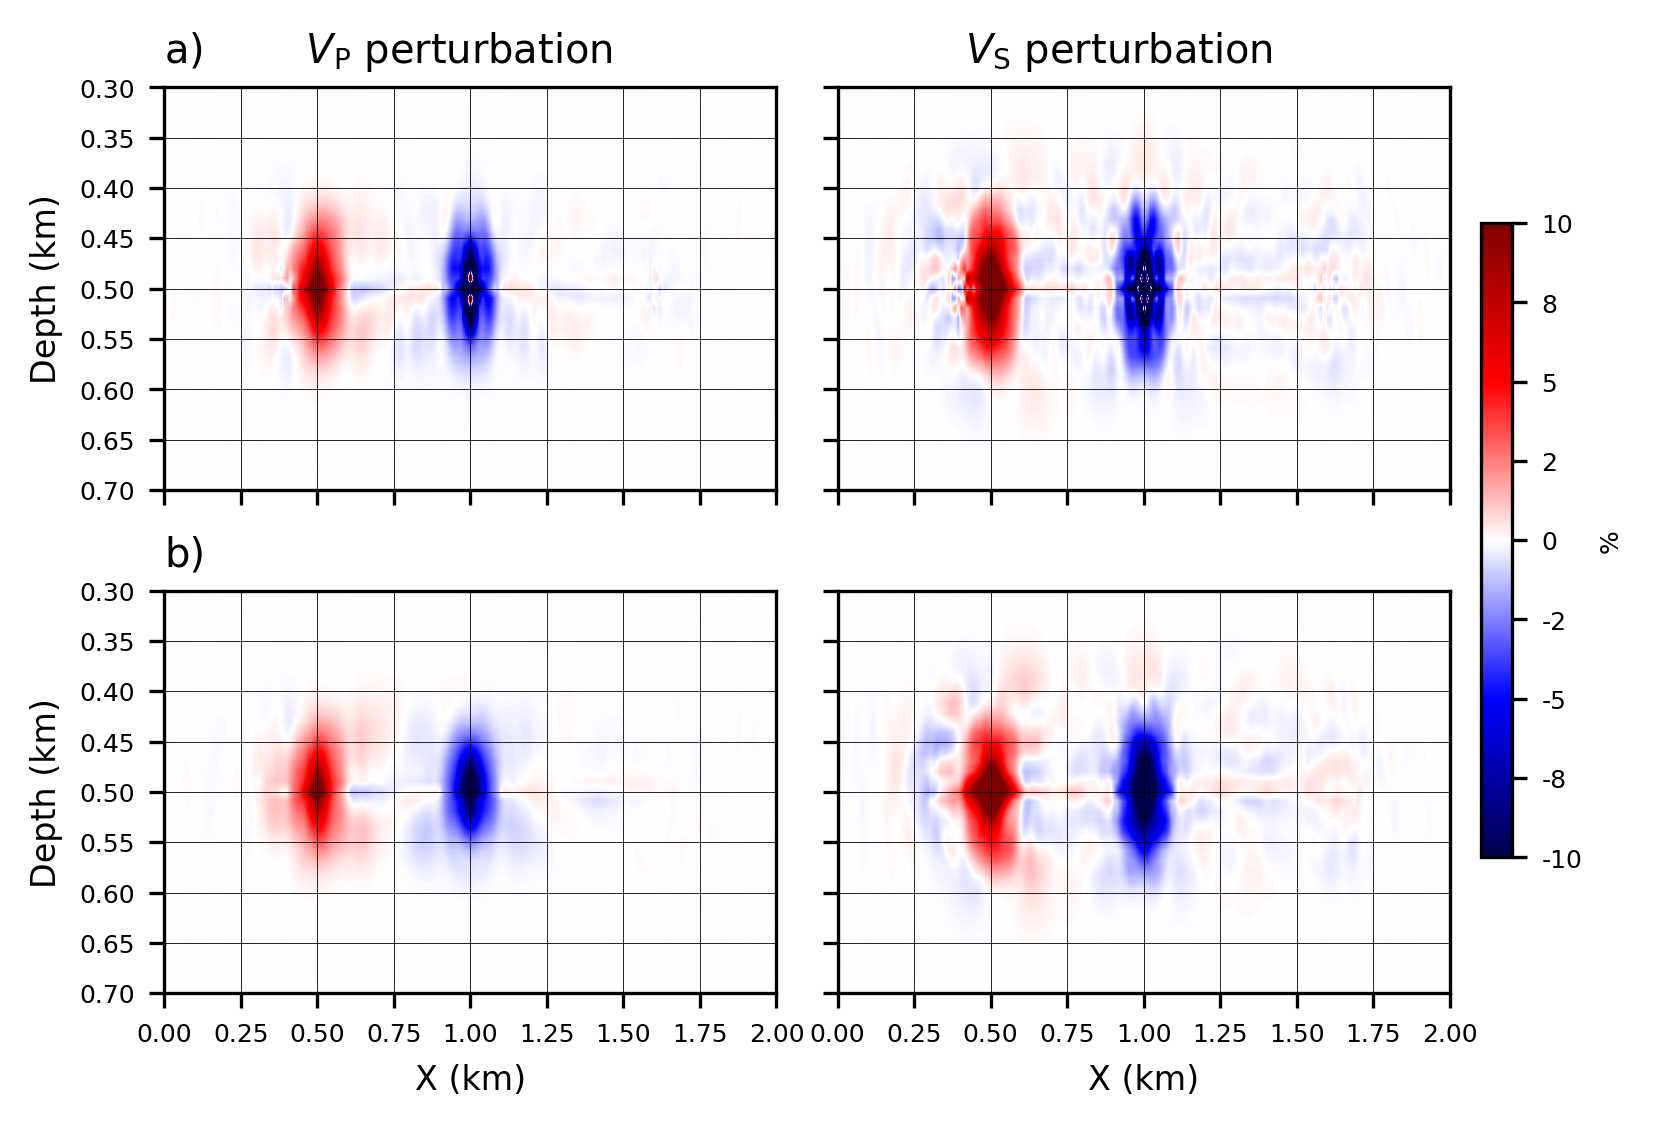

In [9]:
# reference and extended FWI with exact source parameters

temp1=100*(ch5sy_fwi0[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
temp2=100*(ch5sy_fwi0e[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]

fig, ax = plt.subplots(2,2,figsize=(6.66, 4),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)

im0=ax[0,0].imshow(np.transpose(temp1[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,0].set(ylabel='Depth (km)')
ax[0,0].set_xticklabels([])
ax[0,0].set_title(r"a)        $V_{\mathrm{P}}$ perturbation",loc='left')
ax[0,0].tick_params(axis='both', which='major', labelsize=6)
ax[0,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[0,1].imshow(np.transpose(temp1[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title(r"          $V_{\mathrm{S}}$ perturbation",loc='left')
ax[0,1].tick_params(axis='both', which='major', labelsize=6)
ax[0,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[1,0].imshow(np.transpose(temp2[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1,0].set_title(r"b)",loc='left')
ax[1,0].tick_params(axis='both', which='major', labelsize=6)
ax[1,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[1,1].imshow(np.transpose(temp2[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,1].set(xlabel='X (km)')
ax[1,1].set_yticklabels([])
ax[1,1].set_title(r"",loc='left')
ax[1,1].tick_params(axis='both', which='major', labelsize=6)
ax[1,1].grid(color='k', linestyle='-', linewidth=0.2)

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.0f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="%",size=6)

plt.savefig(figpath+'ch5sy_fwi0.png',bbox_inches='tight',format='png')

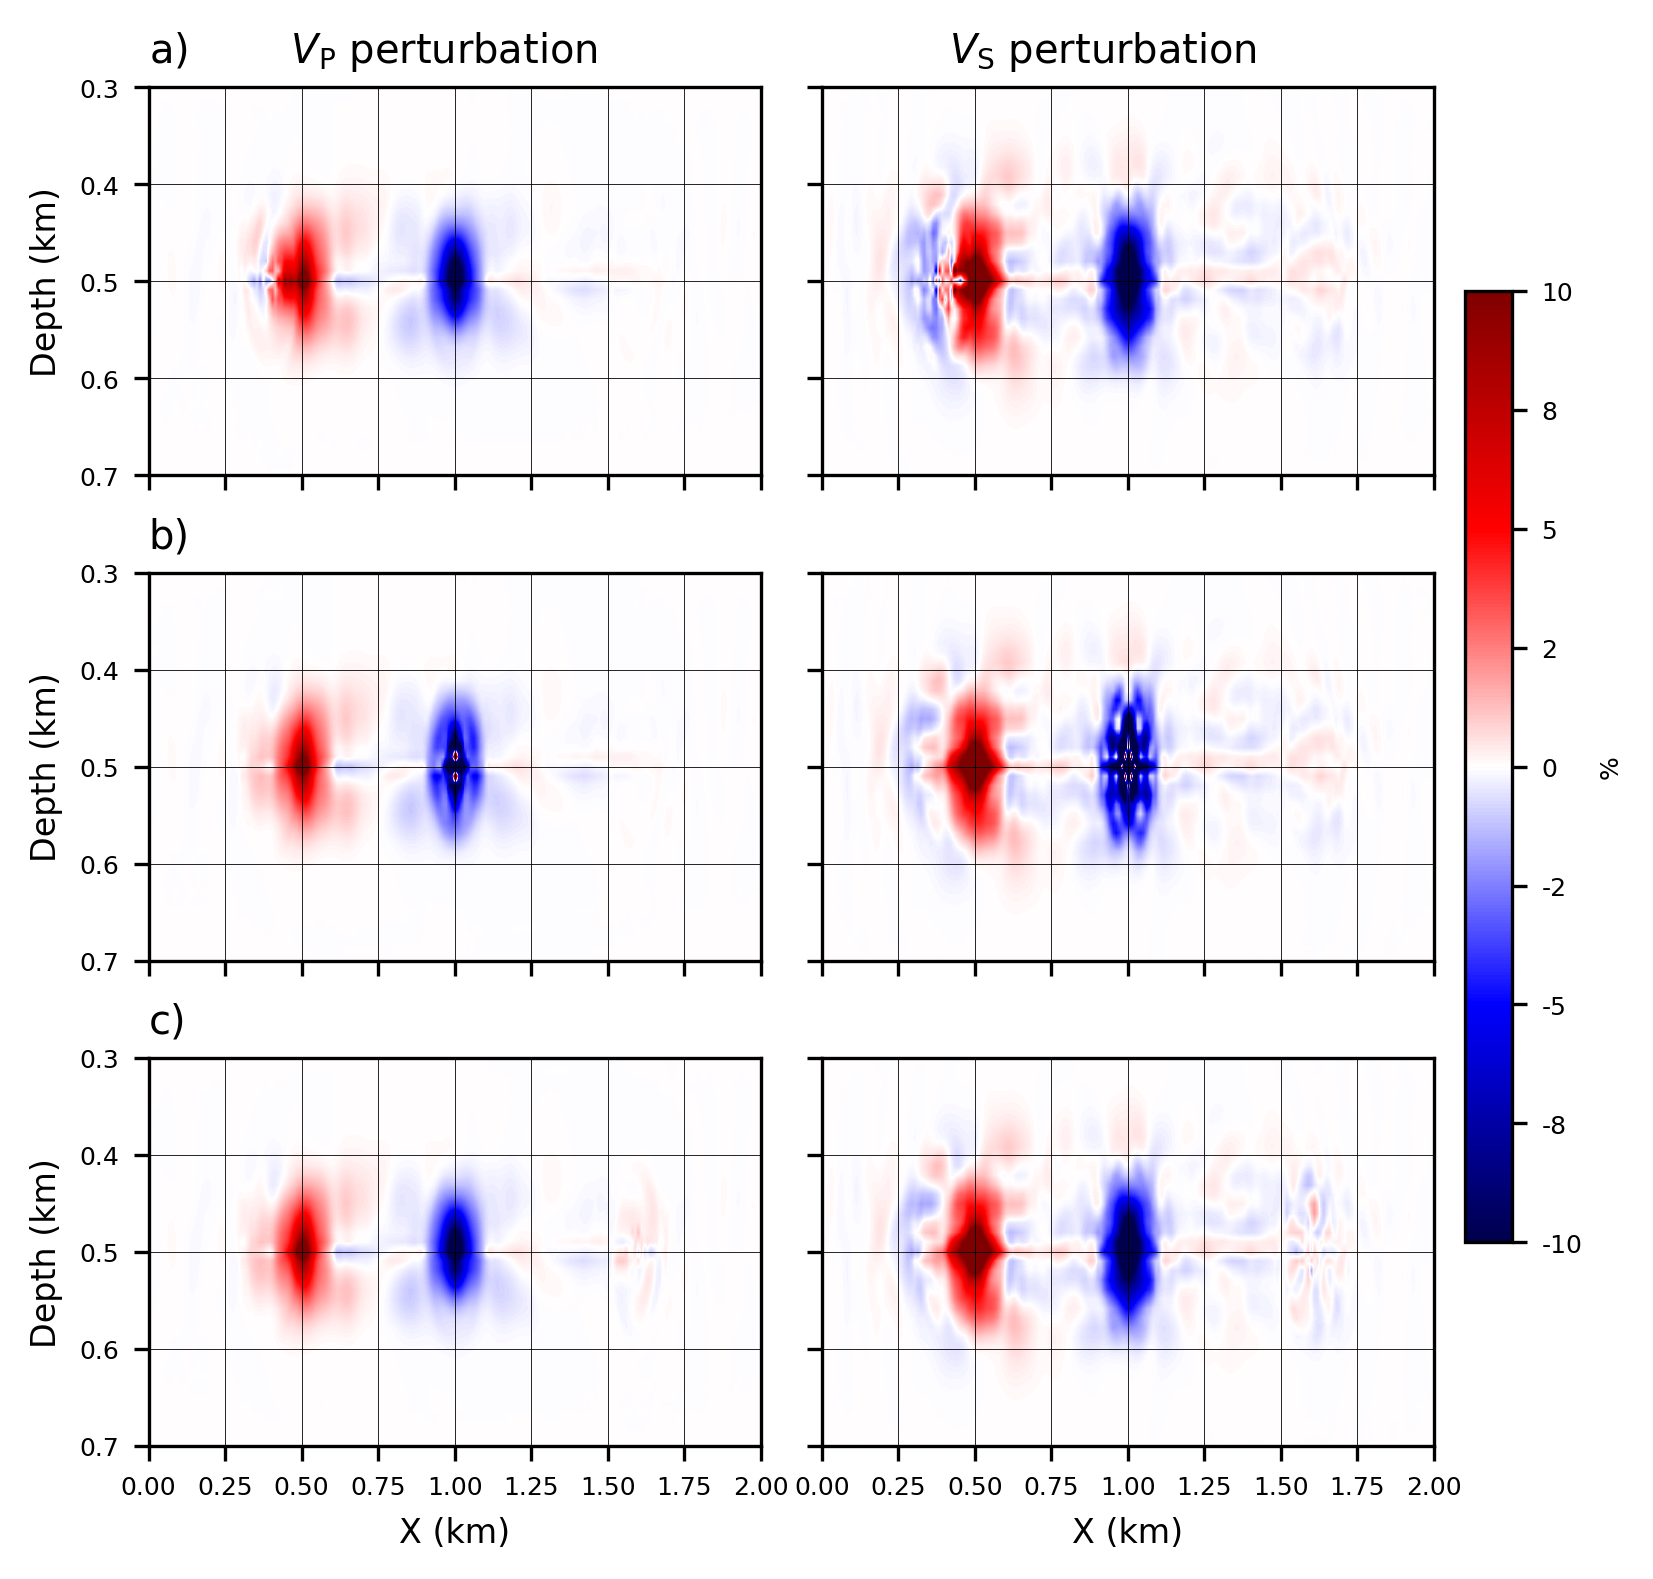

In [10]:
# Final extended perturbation with exact source parameters
temp1=100*(ch5sy_fwi0e_ext[0][0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
temp2=100*(ch5sy_fwi0e_ext[1][0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
temp3=100*(ch5sy_fwi0e_ext[2][0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]

fig, ax = plt.subplots(3,2,figsize=(6.66, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)

im0=ax[0,0].imshow(np.transpose(temp1[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,0].set(ylabel='Depth (km)')
ax[0,0].set_xticklabels([])
ax[0,0].set_title(r"a)        $V_{\mathrm{P}}$ perturbation",loc='left')
ax[0,0].tick_params(axis='both', which='major', labelsize=6)
ax[0,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[0,1].imshow(np.transpose(temp1[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title(r"          $V_{\mathrm{S}}$ perturbation",loc='left')
ax[0,1].tick_params(axis='both', which='major', labelsize=6)
ax[0,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[1,0].imshow(np.transpose(temp2[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,0].set(ylabel='Depth (km)')
ax[1,0].set_xticklabels([])
ax[1,0].set_title(r"b)",loc='left')
ax[1,0].tick_params(axis='both', which='major', labelsize=6)
ax[1,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[1,1].imshow(np.transpose(temp2[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,1].set_title(r"",loc='left')
ax[1,1].tick_params(axis='both', which='major', labelsize=6)
ax[1,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[2,0].imshow(np.transpose(temp3[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[2,0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[2,0].set_title(r"c)",loc='left')
ax[2,0].tick_params(axis='both', which='major', labelsize=6)
ax[2,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[2,1].imshow(np.transpose(temp3[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[2,1].set(xlabel='X (km)')
ax[2,1].set_yticklabels([])
ax[2,1].set_title(r"",loc='left')
ax[2,1].tick_params(axis='both', which='major', labelsize=6)
ax[2,1].grid(color='k', linestyle='-', linewidth=0.2)

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.0f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="%",size=6)

plt.savefig(figpath+'ch5sy_fwi0e_ext.png',bbox_inches='tight',format='png')

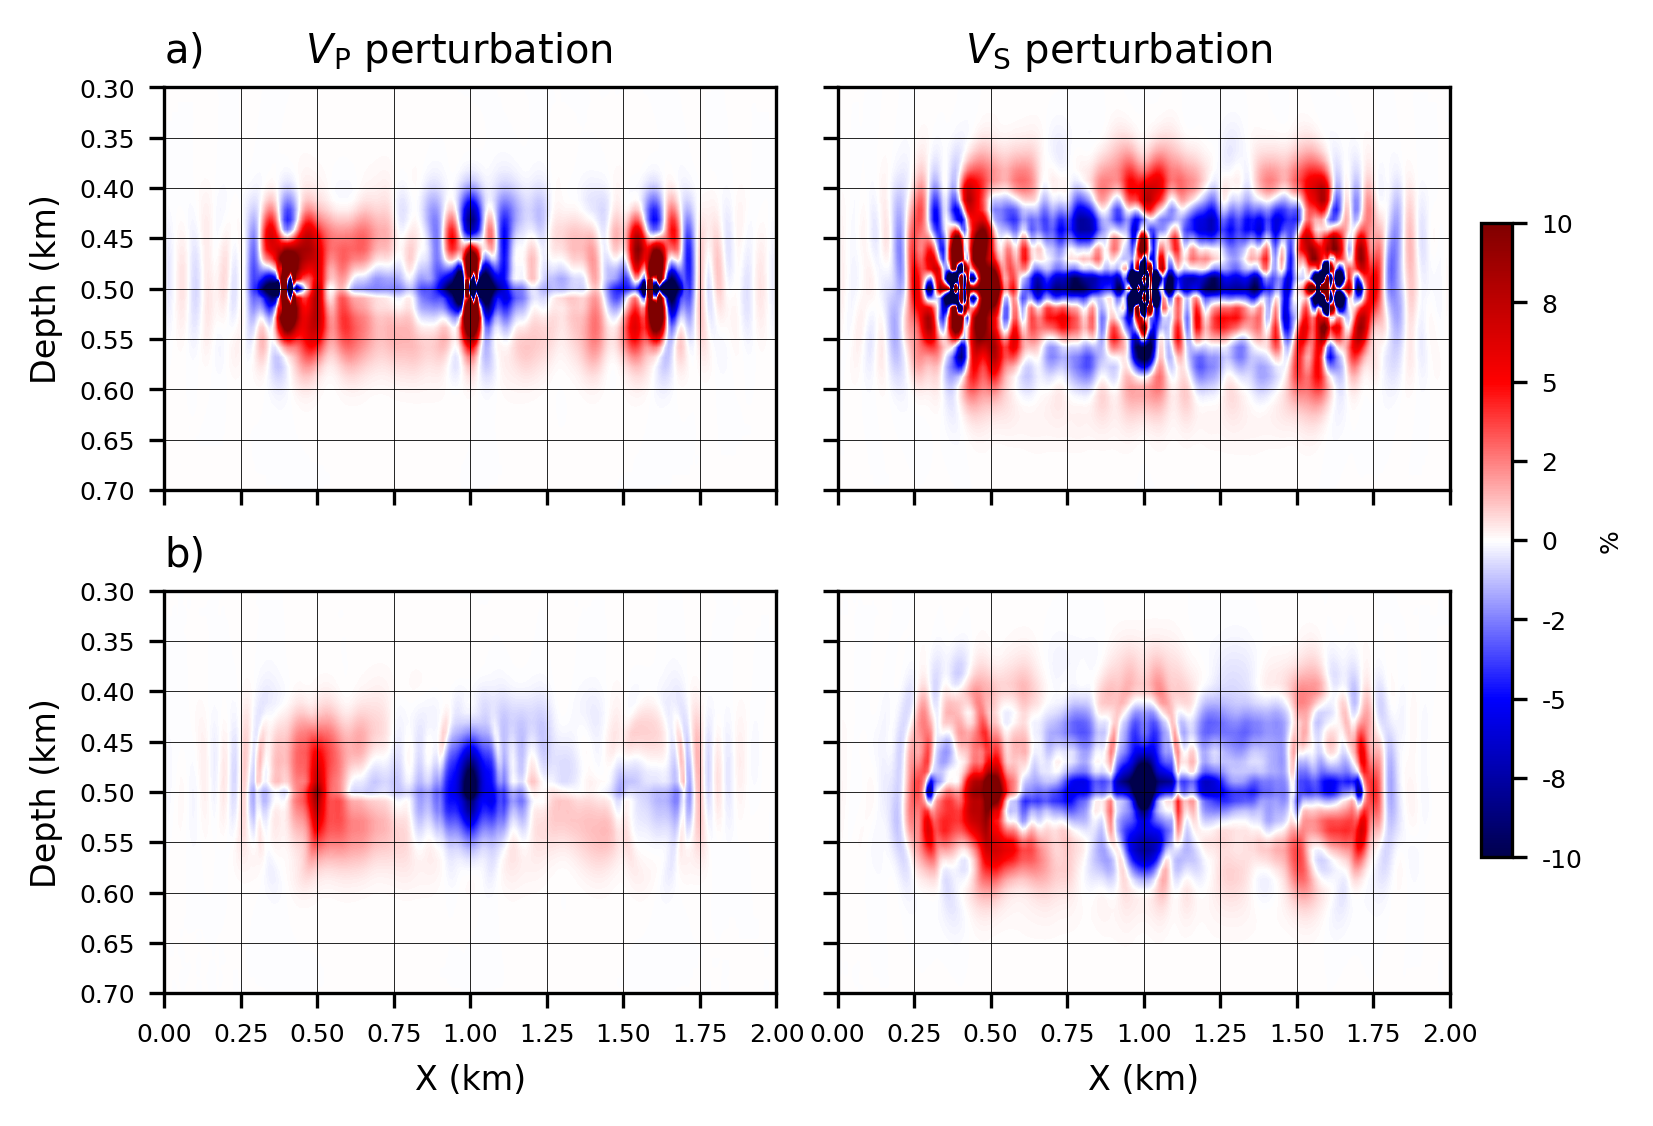

In [11]:
# conventional and extended FWI with source-related errors
temp1=100*(ch5sy_fwi5[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
temp2=100*(ch5sy_fwi5e[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]

fig, ax = plt.subplots(2,2,figsize=(6.66, 4),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)

im0=ax[0,0].imshow(np.transpose(temp1[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,0].set(ylabel='Depth (km)')
ax[0,0].set_xticklabels([])
ax[0,0].set_title(r"a)        $V_{\mathrm{P}}$ perturbation",loc='left')
ax[0,0].tick_params(axis='both', which='major', labelsize=6)
ax[0,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[0,1].imshow(np.transpose(temp1[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title(r"          $V_{\mathrm{S}}$ perturbation",loc='left')
ax[0,1].tick_params(axis='both', which='major', labelsize=6)
ax[0,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[1,0].imshow(np.transpose(temp2[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1,0].set_title(r"b)",loc='left')
ax[1,0].tick_params(axis='both', which='major', labelsize=6)
ax[1,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[1,1].imshow(np.transpose(temp2[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,1].set(xlabel='X (km)')
ax[1,1].set_yticklabels([])
ax[1,1].set_title(r"",loc='left')
ax[1,1].tick_params(axis='both', which='major', labelsize=6)
ax[1,1].grid(color='k', linestyle='-', linewidth=0.2)

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.0f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="%",size=6)

plt.savefig(figpath+'ch5sy_fwi5.png',bbox_inches='tight',format='png')

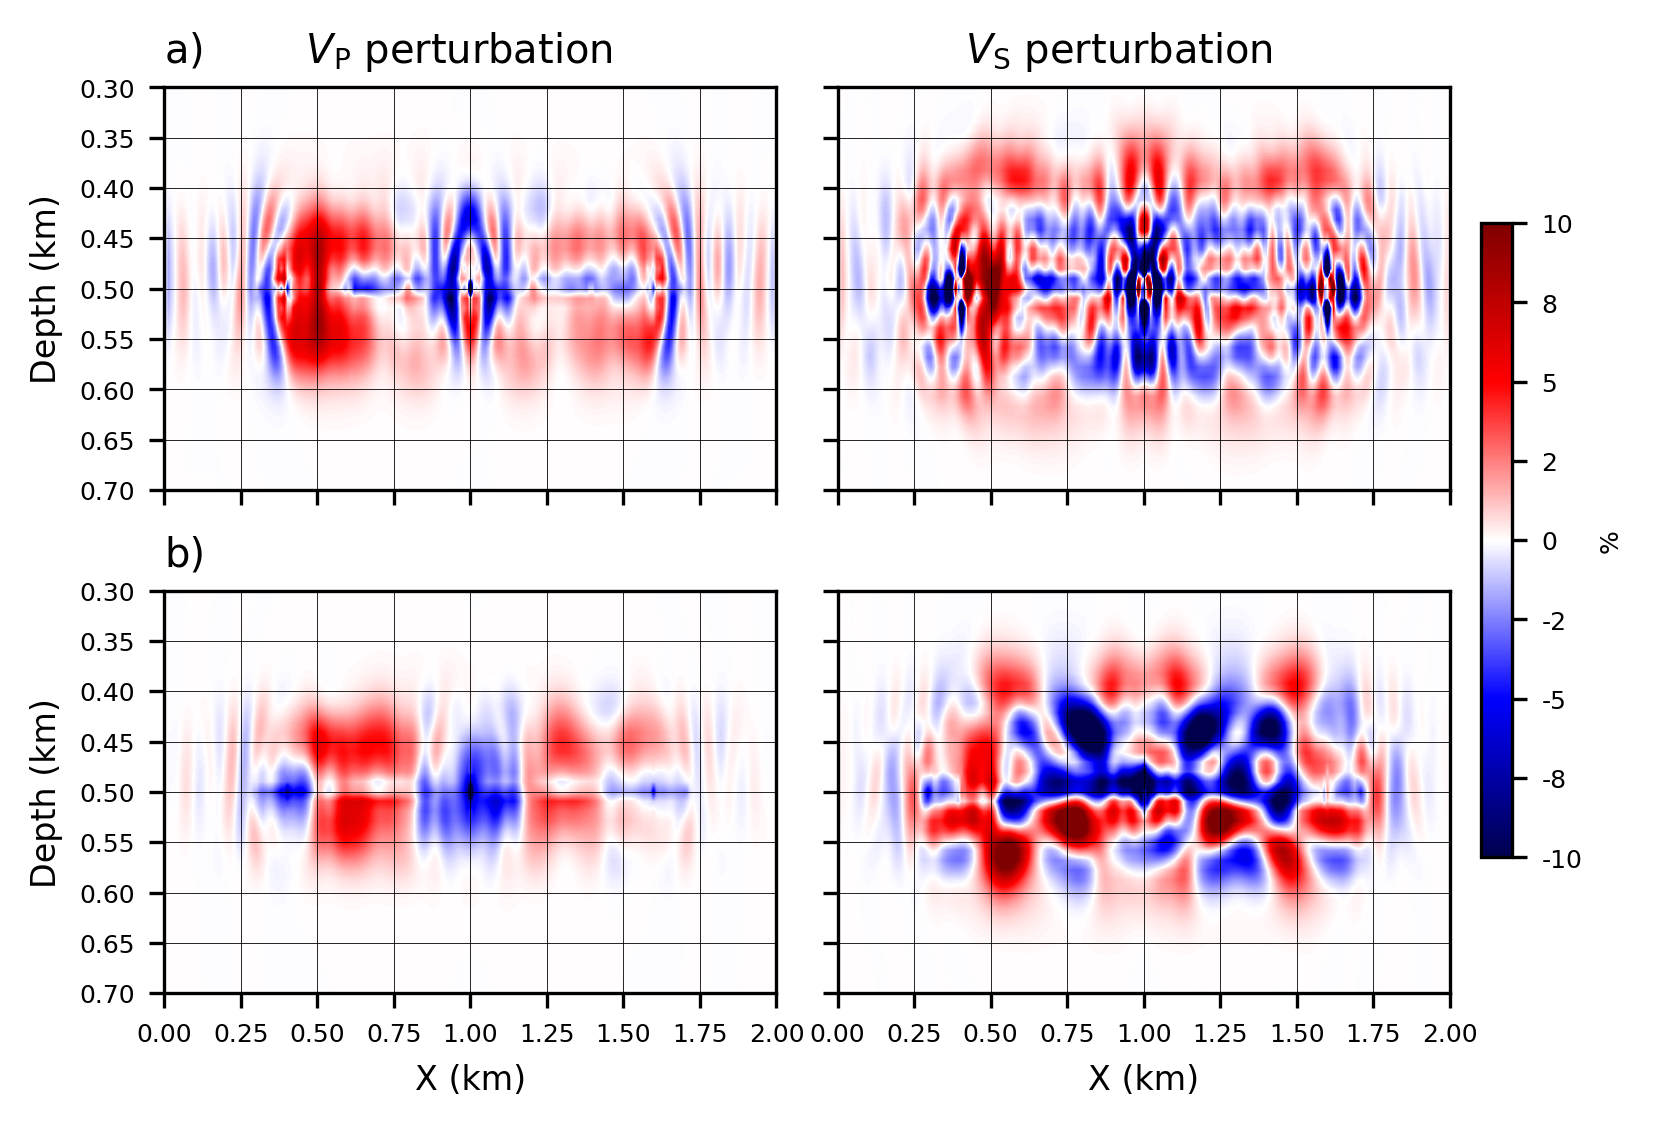

In [12]:
# conventional FWI with source-related errors with mute + pseudo Hessian or gradient preconditioning
temp1=100*(ch5sy_fwi5mh[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]
temp2=100*(ch5sy_fwi5p[0:2,:,:] - ch5sy_model0[0:2,:,:])/ch5sy_model0[0:2,:,:]

fig, ax = plt.subplots(2,2,figsize=(6.66, 4),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)

im0=ax[0,0].imshow(np.transpose(temp1[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,0].set(ylabel='Depth (km)')
ax[0,0].set_xticklabels([])
ax[0,0].set_title(r"a)        $V_{\mathrm{P}}$ perturbation",loc='left')
ax[0,0].tick_params(axis='both', which='major', labelsize=6)
ax[0,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[0,1].imshow(np.transpose(temp1[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title(r"          $V_{\mathrm{S}}$ perturbation",loc='left')
ax[0,1].tick_params(axis='both', which='major', labelsize=6)
ax[0,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[1,0].imshow(np.transpose(temp2[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1,0].set_title(r"b)",loc='left')
ax[1,0].tick_params(axis='both', which='major', labelsize=6)
ax[1,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[1,1].imshow(np.transpose(temp2[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-10,vmax=10)
ax[1,1].set(xlabel='X (km)')
ax[1,1].set_yticklabels([])
ax[1,1].set_title(r"",loc='left')
ax[1,1].tick_params(axis='both', which='major', labelsize=6)
ax[1,1].grid(color='k', linestyle='-', linewidth=0.2)

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.0f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="%",size=6)

plt.savefig(figpath+'ch5sy_fwi5_mh_p.png',bbox_inches='tight',format='png')

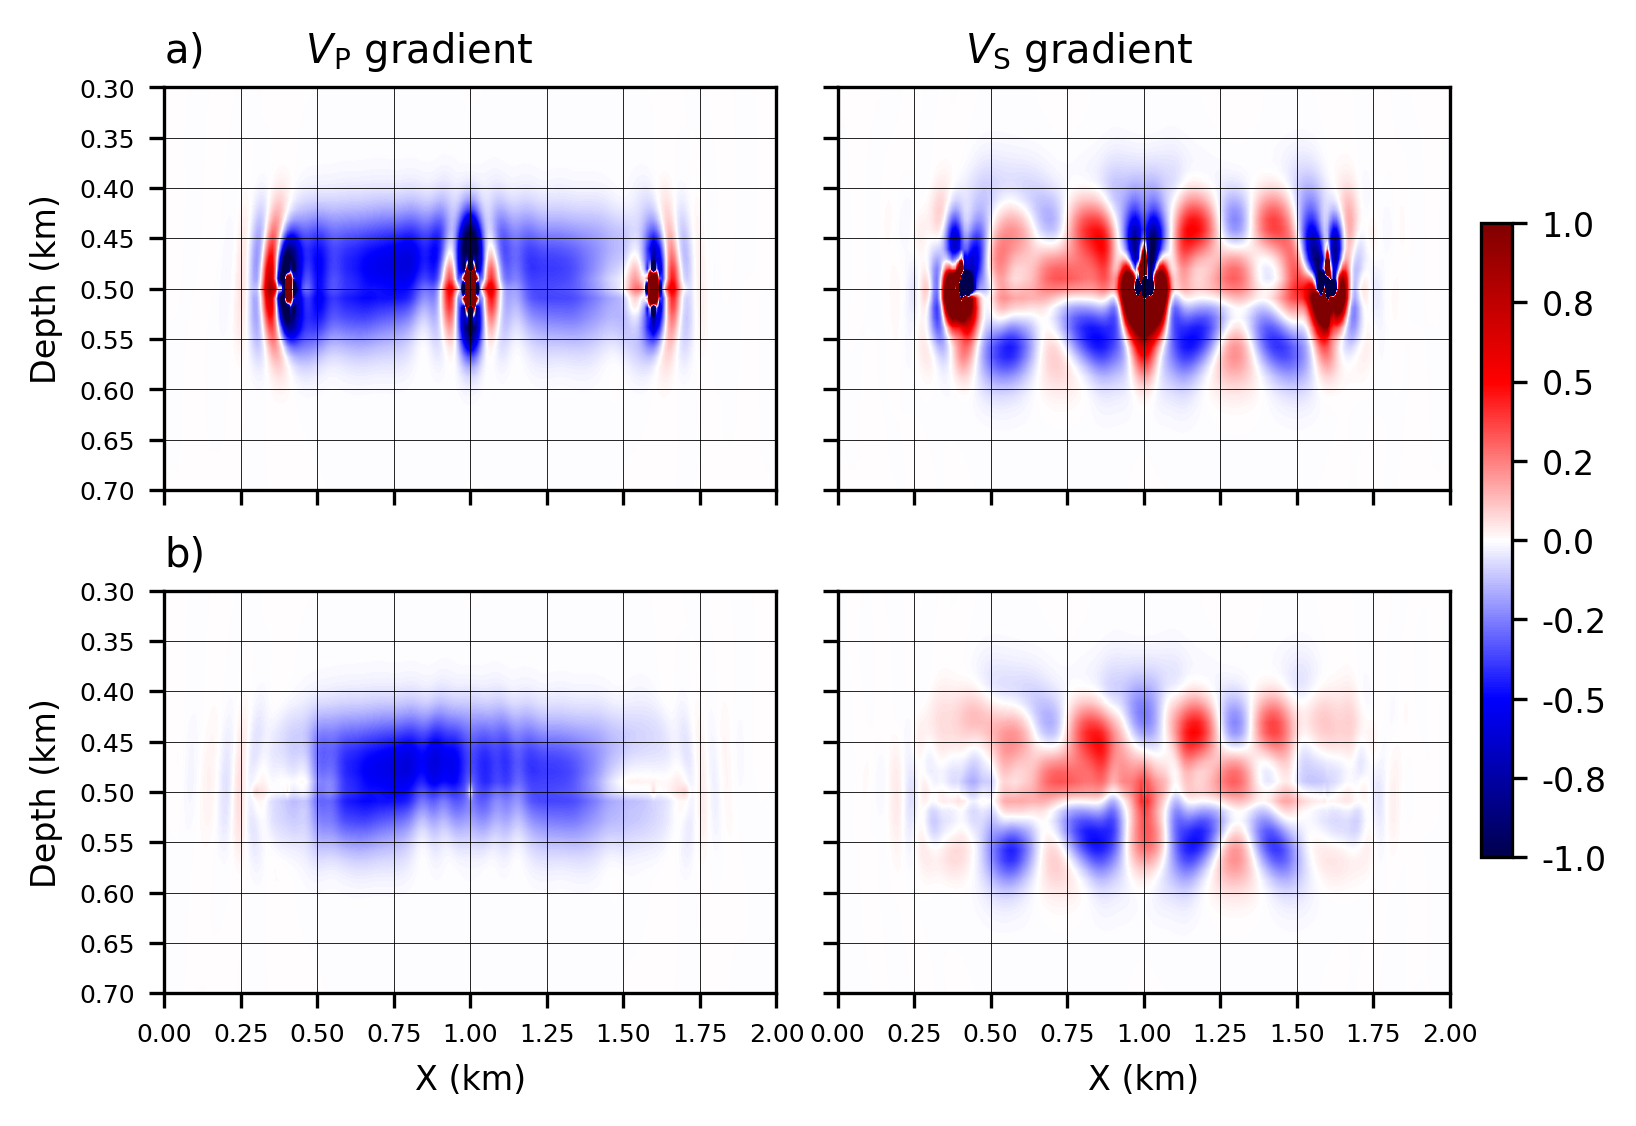

In [5]:
# conventional and extended FWI with source-related errors
temp1=ch5sy_fwi5_grad[0:2,:,:]
temp2=ch5sy_fwi5p_grad[0:2,:,:]

fig, ax = plt.subplots(2,2,figsize=(6.66, 4),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)

im0=ax[0,0].imshow(np.transpose(temp1[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-1,vmax=1)
ax[0,0].set(ylabel='Depth (km)')
ax[0,0].set_xticklabels([])
ax[0,0].set_title(r"a)        $V_{\mathrm{P}}$ gradient",loc='left')
ax[0,0].tick_params(axis='both', which='major', labelsize=6)
ax[0,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[0,1].imshow(np.transpose(temp1[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-1,vmax=1)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title(r"          $V_{\mathrm{S}}$ gradient",loc='left')
ax[0,1].tick_params(axis='both', which='major', labelsize=6)
ax[0,1].grid(color='k', linestyle='-', linewidth=0.2)

im0=ax[1,0].imshow(np.transpose(temp2[0,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-1,vmax=1)
ax[1,0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1,0].set_title(r"b)",loc='left')
ax[1,0].tick_params(axis='both', which='major', labelsize=6)
ax[1,0].grid(color='k', linestyle='-', linewidth=0.2)

im1=ax[1,1].imshow(np.transpose(temp2[1,:,:]),interpolation='bilinear',aspect="auto",extent=[0,2.0,0.7,0.3],cmap="seismic",vmin=-1,vmax=1)
ax[1,1].set(xlabel='X (km)')
ax[1,1].set_yticklabels([])
ax[1,1].set_title(r"",loc='left')
ax[1,1].tick_params(axis='both', which='major', labelsize=6)
ax[1,1].grid(color='k', linestyle='-', linewidth=0.2)

cbar=fig.colorbar(im0, ax=ax.ravel().tolist(), orientation='vertical',shrink=0.7, format="%.1f",pad=0.02)

plt.savefig(figpath+'ch5sy_fwi5_p_gradient.png',bbox_inches='tight',format='png')

In [6]:
# compute cosine similarity between inverted perturbations and true perturbations
cs_list_vp=[]
cs_list_vs=[]

pert_true_vp = ch5sy_model1[0] - ch5sy_model0[0]
pert_fwi0_vp =   ch5sy_fwi0[0] - ch5sy_model0[0]
pert_fwi0e_vp = ch5sy_fwi0e[0] - ch5sy_model0[0]
pert_fwi5_vp =   ch5sy_fwi5[0] - ch5sy_model0[0]
pert_fwi5e_vp = ch5sy_fwi5e[0] - ch5sy_model0[0]
pert_fwi5mh_vp = ch5sy_fwi5mh[0] - ch5sy_model0[0]
pert_fwi5p_vp = ch5sy_fwi5p[0] - ch5sy_model0[0]

pert_true_vs = ch5sy_model1[1] - ch5sy_model0[1]
pert_fwi0_vs =   ch5sy_fwi0[1] - ch5sy_model0[1]
pert_fwi0e_vs = ch5sy_fwi0e[1] - ch5sy_model0[1]
pert_fwi5_vs =   ch5sy_fwi5[1] - ch5sy_model0[1]
pert_fwi5e_vs = ch5sy_fwi5e[1] - ch5sy_model0[1]
pert_fwi5mh_vs = ch5sy_fwi5mh[1] - ch5sy_model0[1]
pert_fwi5p_vs = ch5sy_fwi5p[1] - ch5sy_model0[1]

cs = np.dot(pert_true_vp.flatten(),pert_fwi0_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi0_vp))
cs_list_vp.append(cs)
cs = np.dot(pert_true_vp.flatten(),pert_fwi0e_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi0e_vp))
cs_list_vp.append(cs)
cs = np.dot(pert_true_vp.flatten(),pert_fwi5_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi5_vp))
cs_list_vp.append(cs)
cs = np.dot(pert_true_vp.flatten(),pert_fwi5e_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi5e_vp))
cs_list_vp.append(cs)
cs = np.dot(pert_true_vp.flatten(),pert_fwi5mh_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi5mh_vp))
cs_list_vp.append(cs)
cs = np.dot(pert_true_vp.flatten(),pert_fwi5p_vp.flatten())/(np.linalg.norm(pert_true_vp) * np.linalg.norm(pert_fwi5p_vp))
cs_list_vp.append(cs)

cs = np.dot(pert_true_vs.flatten(),pert_fwi0_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi0_vs))
cs_list_vs.append(cs)
cs = np.dot(pert_true_vs.flatten(),pert_fwi0e_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi0e_vs))
cs_list_vs.append(cs)
cs = np.dot(pert_true_vs.flatten(),pert_fwi5_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi5_vs))
cs_list_vs.append(cs)
cs = np.dot(pert_true_vs.flatten(),pert_fwi5e_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi5e_vs))
cs_list_vs.append(cs)
cs = np.dot(pert_true_vs.flatten(),pert_fwi5mh_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi5mh_vs))
cs_list_vs.append(cs)
cs = np.dot(pert_true_vs.flatten(),pert_fwi5p_vs.flatten())/(np.linalg.norm(pert_true_vs) * np.linalg.norm(pert_fwi5p_vs))
cs_list_vs.append(cs)

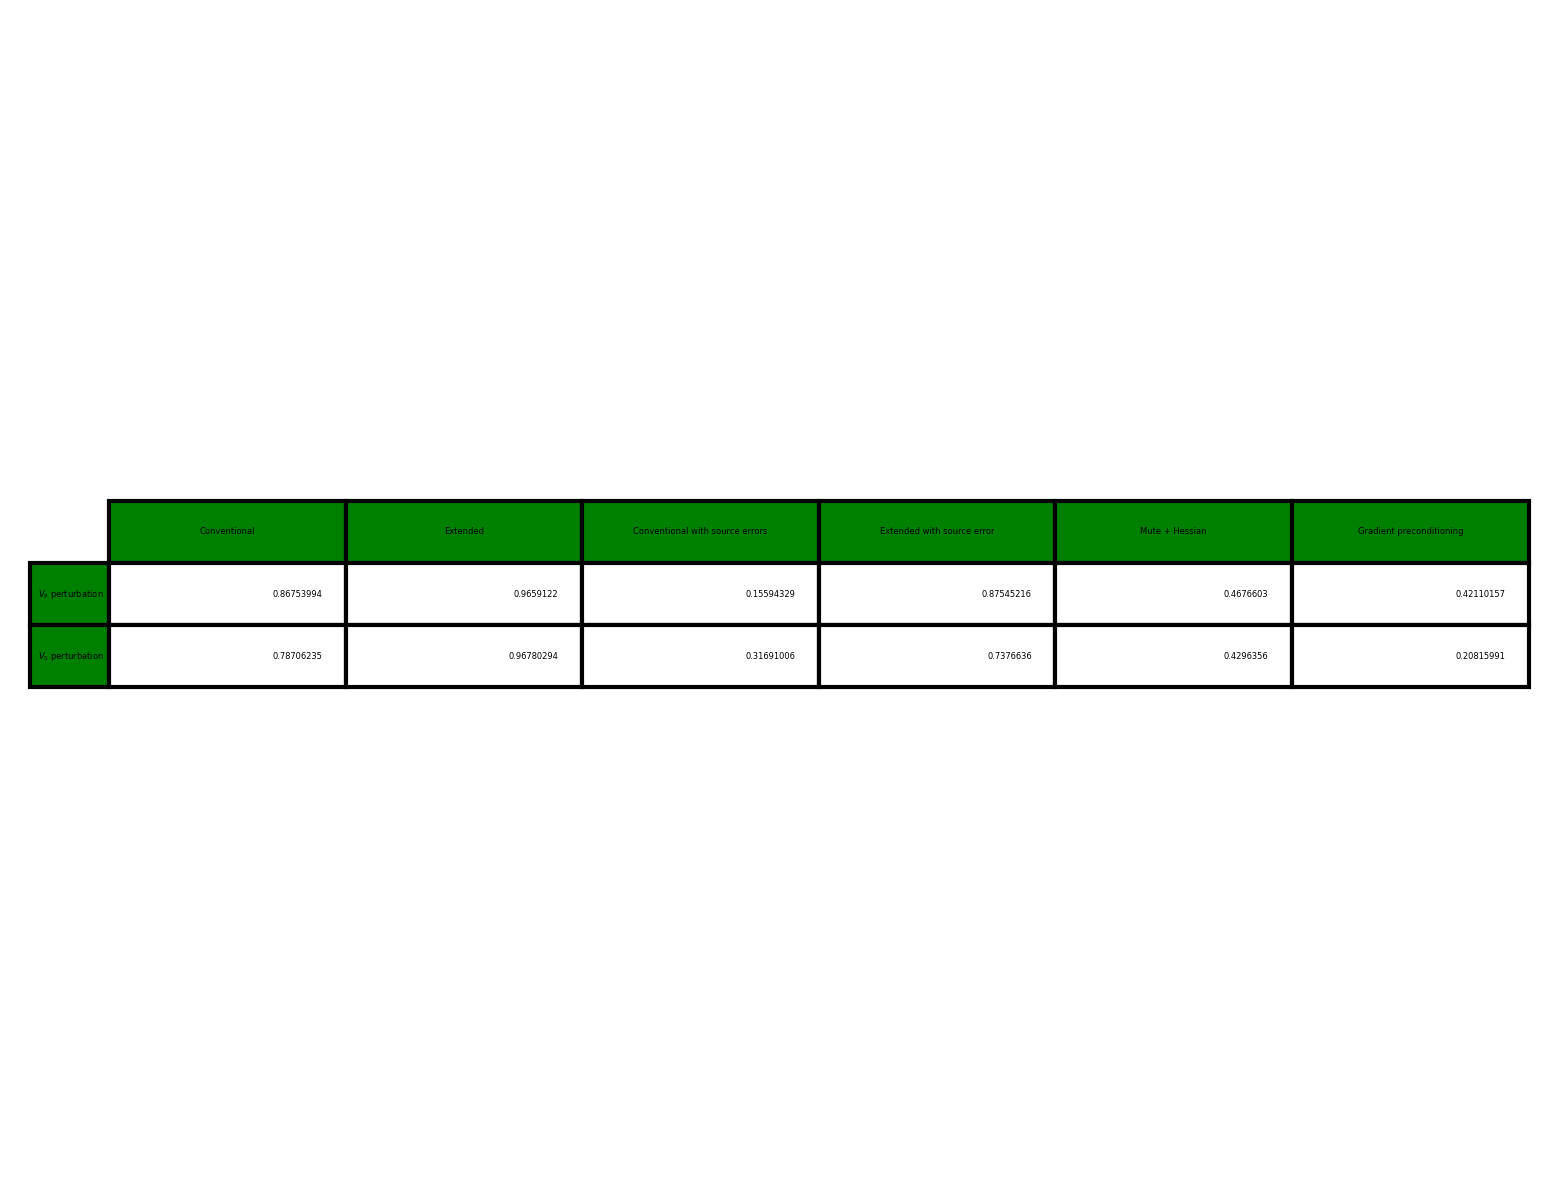

In [7]:
# plot the summary table ; the values will be copied manually into the report/paper/thesis

fig, ax = plt.subplots(dpi=300)
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=[cs_list_vp,cs_list_vs], 
         rowLabels=[r"$V_\mathrm{P}$ perturbation",r"$V_\mathrm{S}$ perturbation"],
         colLabels=["Conventional","Extended","Conventional with source errors","Extended with source error", "Mute + Hessian", "Gradient preconditioning"], 
         rowColours=['g','g','g','g','g','g'],
         colColours=['g','g','g','g','g','g'],
         loc='center')

fig.tight_layout()

plt.show()

In [8]:
# read misfit functions

axes, data = sep.read_file(datapath+"ch5sy_fwi0.H.func")
ch5sy_fwi0_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5.H.func")
ch5sy_fwi5_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H.func")
ch5sy_fwi0e_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H.func.d")
ch5sy_fwi0e_func_d = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi0e.H.func.m")
ch5sy_fwi0e_func_m = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5e.H.func")
ch5sy_fwi5e_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5e.H.func.d")
ch5sy_fwi5e_func_d = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5e.H.func.m")
ch5sy_fwi5e_func_m = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5m.H.func")
ch5sy_fwi5m_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5mb.H.func")
ch5sy_fwi5mb_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5mh.H.func")
ch5sy_fwi5mh_func = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_fwi5p.H.func")
ch5sy_fwi5p_func = data.reshape(axes.n,order='F').T

In [9]:
# remove unwanted (intermediate) trial values for the extended FWI

select_list=[]
for i in range(ch5sy_fwi0e_func_d.shape[0]):
    if int(100000*(ch5sy_fwi0e_func_d[i]+ch5sy_fwi0e_func_m[i])) in (100000*ch5sy_fwi0e_func).astype(int):
        select_list.append(i)
ch5sy_fwi0e_func_d = ch5sy_fwi0e_func_d[select_list]
ch5sy_fwi0e_func_m = ch5sy_fwi0e_func_m[select_list]

select_list=[]
for i in range(ch5sy_fwi5e_func_d.shape[0]):
    if int(500*(ch5sy_fwi5e_func_d[i]+ch5sy_fwi5e_func_m[i])) in (500*ch5sy_fwi5e_func).astype(int):
        select_list.append(i)
ch5sy_fwi5e_func_d = ch5sy_fwi5e_func_d[select_list]
ch5sy_fwi5e_func_m = ch5sy_fwi5e_func_m[select_list]

In [10]:
# collect the misfit functions to be plotted together

xfunc = [np.arange(0,ch5sy_fwi0_func.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi0e_func_d.shape[0],dtype=int),
         np.arange(0,ch5sy_fwi5_func.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi5e_func_d.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi5m_func.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi5mb_func.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi5mh_func.shape[0],dtype=int), 
         np.arange(0,ch5sy_fwi5p_func.shape[0],dtype=int)]

yfunc = [ch5sy_fwi0_func, 
         ch5sy_fwi0e_func_d, 
         ch5sy_fwi5_func, 
         ch5sy_fwi5e_func_d, 
         ch5sy_fwi5m_func, 
         ch5sy_fwi5mb_func, 
         ch5sy_fwi5mh_func, 
         ch5sy_fwi5p_func]

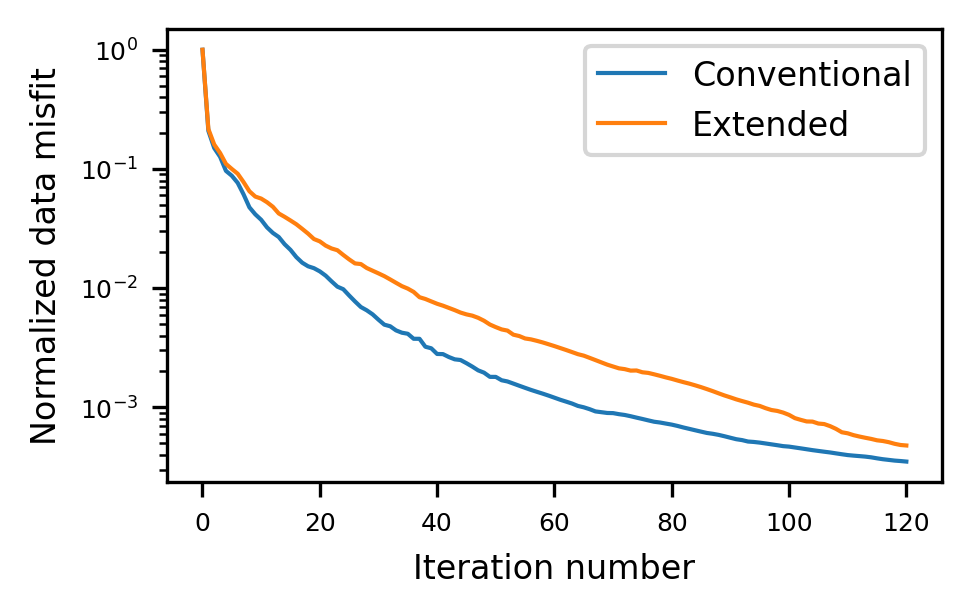

In [19]:
plotfunc([xfunc[0],xfunc[1]], [yfunc[0]/yfunc[0][0],yfunc[1]/yfunc[1][0]], ymin=0, ymax=0, yscale="log", ylabel="Normalized data misfit", labels=["Conventional","Extended"], legend=True, savefig="ch5sy_data_misfit_noerror")

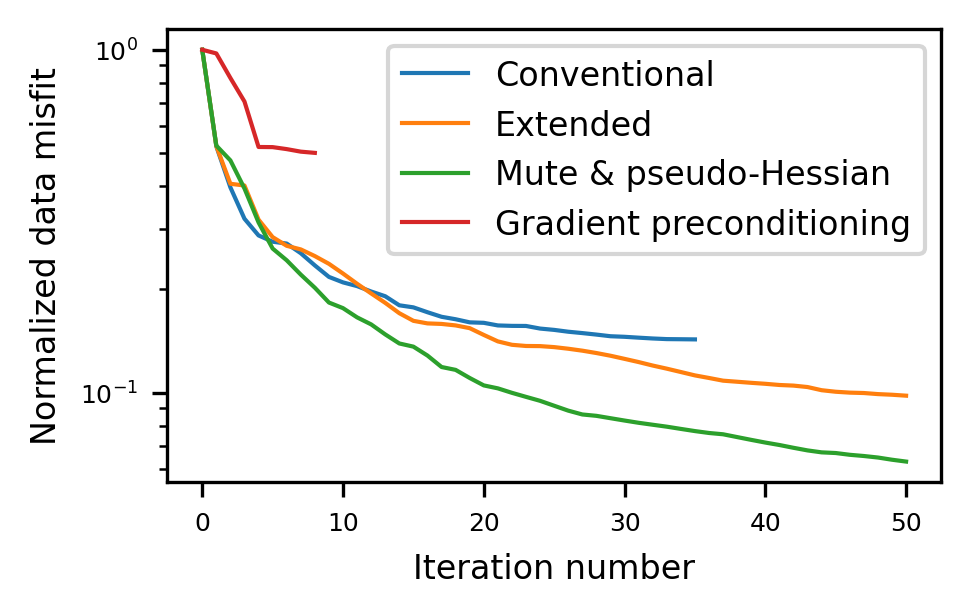

In [20]:
plotfunc([xfunc[2],xfunc[3],xfunc[6],xfunc[7]], [yfunc[2]/yfunc[2][0],yfunc[3]/yfunc[3][0],yfunc[6]/yfunc[6][0],yfunc[7]/yfunc[7][0]], ymin=0, ymax=0, yscale="log", ylabel="Normalized data misfit", labels=["Conventional","Extended","Mute & pseudo-Hessian","Gradient preconditioning"], legend=True, savefig="ch5sy_data_misfit_witherror")

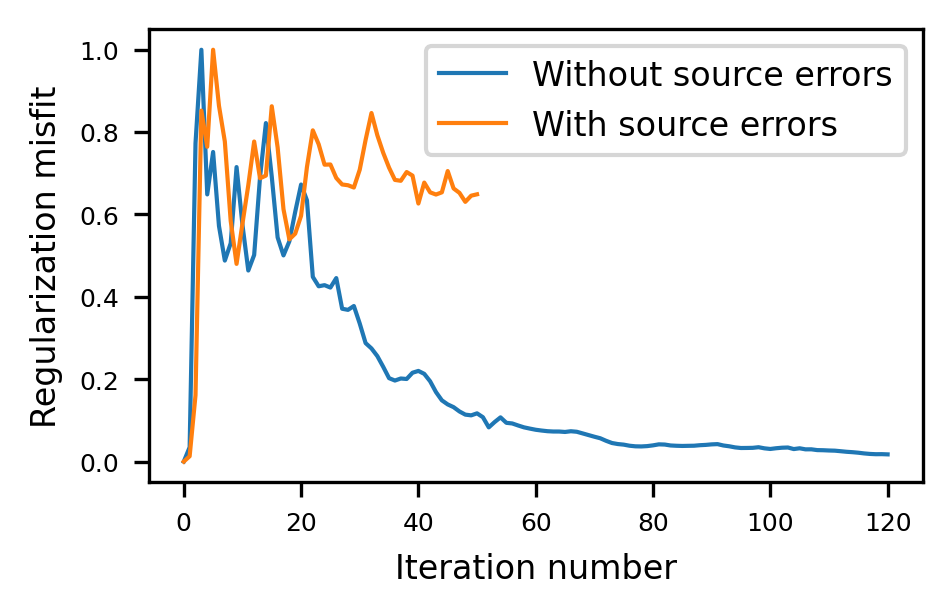

In [11]:
plotfunc([xfunc[1],xfunc[3]], [ch5sy_fwi0e_func_m/np.max(ch5sy_fwi0e_func_m),ch5sy_fwi5e_func_m/np.max(ch5sy_fwi5e_func_m)], ymin=0, ymax=0, yscale="linear", ylabel="Regularization misfit", labels=["Without source errors","With source errors"], legend=True, savefig="ch5sy_regul_misfit")

In [24]:
# read time functions

axes, data = sep.read_file(datapath+"ch5sy_wavelet0.H")
ch5sy_wavelet0 = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"ch5sy_wavelet1.H")
ch5sy_wavelet1 = data.reshape(axes.n,order='F').T

Relative wavelet error = 16.5%


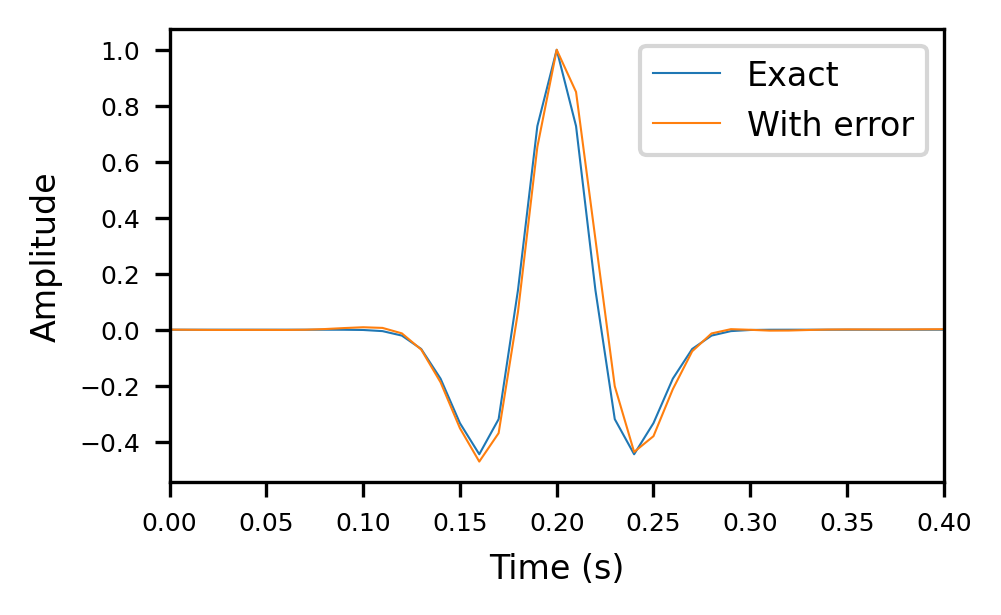

In [25]:
fig=plt.figure(figsize=(3.33, 2),dpi=300)
plt.plot(np.arange(0,(axes.n[0])*axes.d[0],axes.d[0]),ch5sy_wavelet0,label="Exact",     Linewidth=0.5)
plt.plot(np.arange(0,(axes.n[0])*axes.d[0],axes.d[0]),ch5sy_wavelet1,label="With error",Linewidth=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([0,0.4])
plt.legend()
plt.gca().tick_params(axis='both', which='major', labelsize=6)

plt.savefig(figpath+"ch5sy_wavelet.png",bbox_inches='tight',format='png')

error = 100*np.linalg.norm(ch5sy_wavelet1-ch5sy_wavelet0)/np.linalg.norm(ch5sy_wavelet0)
print("Relative wavelet error = %.1f%%" %error)